In [1]:
%pip install soxr


Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -qU keras librosa tensorflow tensorboard


Note: you may need to restart the kernel to use updated packages.


In [2]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

# basic algebra and system libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as path
import pandas as pd
import gc

# signal discrete fourier transform and loading
import scipy.signal as signal
import scipy.io.wavfile as wavfile
import scipy.fft as fft

# audio preprocessing, cross validation and others
from sklearn.base import TransformerMixin, BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.model_selection import cross_val_score

# construction of convolutional neural network
import keras
import keras.optimizers as optimizers
import keras.layers as layers
import keras.losses as losses
import keras.metrics as metrics
import keras.regularizers as regularizers

# audio analysis
import librosa
import librosa.display

# processing speedup using gpu
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# allow gpu computation to exceed system memory for a certain amount
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


## Data Loading

In [4]:
metadata = {}
data_dir = os.path.join("..", "data", "raw")
metadata['data_dir'] = data_dir
metadata['path'] = []
metadata['label'] = []
class_1_speakers = ['f1', 'f7', 'f8', 'm3', 'm6', 'm8']
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".wav"):
            metadata['path'].append(file)
            speaker_id = file.split('_')[0]
            label = 1 if speaker_id in class_1_speakers else 0
            metadata['label'].append(label)
            
            
audios = [ wavfile.read(path.join("..", "data", "raw", audio_path)) for audio_path in metadata['path'] ]
metadata['rate'] = [ sample_rate for sample_rate, _ in audios ]
metadata['signal'] = [ wave for _, wave in audios ]


## Audio Preprocessing

In [5]:
from sklearn.base import TransformerMixin
class AudioPreprocessor(TransformerMixin):
    def __init__(self, sr: int = 16000) -> None:
        self.sr = sr

    def fit(self, X, y = None, **params):
        X_resampled = X.copy()
        # first resample to target frequency 16000, as audio signals are storead as 16-bit signed integers, we need to normalize them  by dividing by 32768
        X_resampled['signal'] = [ librosa.resample(signal / 32768, orig_sr = rate, target_sr = self.sr, res_type = 'soxr_qq') if rate != self.sr else (signal / 32768) for rate, signal in zip(X_resampled['rate'], X_resampled['signal']) ]
        # expect X to be full dataset with signal column holding wave signal arrays
        # learn fixed count of samples from trimmed wave signals
        #trimmed slcices mean that we remove sections of the signal where the amplitude is below top_db
        trimmed = [ librosa.effects.trim(audio, top_db = 20)[0] for audio in X_resampled['signal'] ]
        # take 95% percentile to compute the chosen length for all recordings
        self.samples = int(np.percentile([ audio.shape[0] - np.argmin((audio == 0)[::-1]) for audio in trimmed ], 95))
        
        return self

    def transform(self, X, y = None, **params):
        X_resampled = X.copy()
        # first resample to target frequency 16000
        X_resampled['signal'] = [ librosa.resample(signal / 32768, orig_sr = rate, target_sr = self.sr, res_type = 'soxr_qq') if rate != self.sr else (signal / 32768) for rate, signal in zip(X_resampled['rate'], X_resampled['signal']) ]
        # trim and pad wave files
        trimmed = [ librosa.effects.trim(audio, top_db = 20)[0] for audio in X_resampled['signal'] ]
        waves = np.stack([ audio[:self.samples] if audio.shape[0] >= self.samples else np.pad(audio, (0, self.samples - audio.shape[0]), constant_values = (0, 0)) for audio in trimmed ], axis = 0)    
        # result is wave signals with corresponding indexes
        return waves


## Spectrogram Extraction

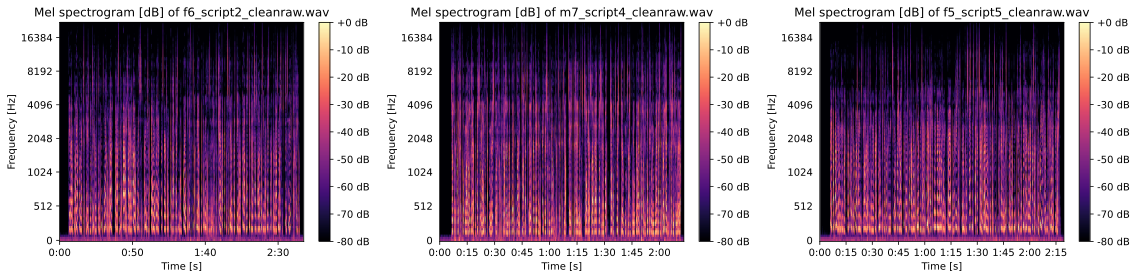

In [6]:
from sklearn.base import TransformerMixin


class MelSpectrogram(TransformerMixin):
    # Extracts spectrogram with frequencies in Mel scale, thus Mel spectrogram
    def __init__(self, sr: int = 16000) -> None:
        self.sr = sr
    
    def fit(self, X, y = None, **params):
        return self
    
    def transform(self, X, y = None, **params):
        # extraction of Mel spectrograms
        spectrograms = np.array([ 
            librosa.feature.melspectrogram(
                y = x, 
                sr = self.sr,
                n_fft = 2048, 
                hop_length = 512,
                n_mels = 128
            ) 
            for x in X 
        ])
        # one unitary dimension is added to make data format
        # compatible with respect to keras input
        return np.expand_dims(spectrograms, axis = -1)

# example "dirty" spectrogram
audio_id = 90

# Create the first spectrogram
spectrogram1 = librosa.feature.melspectrogram(
    y = metadata['signal'][audio_id] / 32768,
    sr = metadata['rate'][audio_id],
    n_fft = 2048, 
    hop_length = 512,
    n_mels = 128
)

# Create the second spectrogram (can be a different audio file or manipulated version of the first)
audio_id2 = 11
spectrogram2 = librosa.feature.melspectrogram(
    y = metadata['signal'][audio_id2] / 32768,
    sr = metadata['rate'][audio_id2],
    n_fft = 2048, 
    hop_length = 512,
    n_mels = 128
)

audio_id3 = 3
spectrogram3 = librosa.feature.melspectrogram(
    y = metadata['signal'][audio_id3] / 32768,
    sr = metadata['rate'][audio_id3],
    n_fft = 2048, 
    hop_length = 512,
    n_mels = 128
)

# Create subplots for two spectrograms
fig, axs = plt.subplots(1, 3, figsize=(16, 4))  # 1 row, 2 columns for side-by-side plots

# Display first spectrogram
img1 = librosa.display.specshow(
    librosa.power_to_db(spectrogram1, ref = np.max),
    sr = metadata['rate'][audio_id],
    n_fft = 2048, 
    hop_length = 512,
    x_axis = 'time',
    y_axis = 'mel',
    cmap = 'magma',
    ax = axs[0]  # Plot on the first axis
)
axs[0].set_title(f"Mel spectrogram [dB] of {os.path.basename(metadata['path'][audio_id])}")
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Frequency [Hz]')
fig.colorbar(img1, ax=axs[0], format='%+2.0f dB')

# Display second spectrogram
img2 = librosa.display.specshow(
    librosa.power_to_db(spectrogram2, ref = np.max),
    sr = metadata['rate'][audio_id2],
    n_fft = 2048, 
    hop_length = 512,
    x_axis = 'time',
    y_axis = 'mel',
    cmap = 'magma',
    ax = axs[1]  # Plot on the second axis
)
axs[1].set_title(f"Mel spectrogram [dB] of {os.path.basename(metadata['path'][audio_id2])}")
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Frequency [Hz]')
axs[1].tick_params(left=False)
fig.colorbar(img2, ax=axs[1], format='%+2.0f dB')

# Display second spectrogram
img3 = librosa.display.specshow(
    librosa.power_to_db(spectrogram3, ref = np.max),
    sr = metadata['rate'][audio_id3],
    n_fft = 2048, 
    hop_length = 512,
    x_axis = 'time',
    y_axis = 'mel',
    cmap = 'magma',
    ax = axs[2]  # Plot on the second axis
)
axs[2].set_title(f"Mel spectrogram [dB] of {os.path.basename(metadata['path'][audio_id3])}")
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Frequency [Hz]')
axs[2].tick_params(left=False)
fig.colorbar(img3, ax=axs[2], format='%+2.0f dB')

# Show the plot
plt.tight_layout()
plt.show()


## Model Architecture Definition

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_convolutional_neural_network(input_shape, n_classes):
    # Defining the model using TensorFlow/Keras
    model = models.Sequential([
        # Input shape of Mel-spectrogram (n_mels, n_frames)
        layers.Input(shape=input_shape),

        # Add Gaussian noise to input data
        layers.GaussianNoise(0.1),

        # First convolutional block
        layers.Conv2D(16, (7, 7), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional block
        #layers.Conv2D(32, (5, 5), activation='relu'),
        #layers.BatchNormalization(),
        #layers.Dropout(0.25),
        #layers.MaxPooling2D((2, 2)),

        # Third convolutional block
        #layers.Conv2D(64, (5, 5), activation='relu'),
        #layers.BatchNormalization(),
        #layers.Dropout(0.25),
        #layers.MaxPooling2D((2, 2)),

        # Flatten the 2D data into 1D to prepare for the Dense layers
        layers.Flatten(),

        # Fully connected layer with 128 units
        layers.Dense(16, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output layer with softmax activation for multi-class classification
        layers.Dense(n_classes, activation='softmax')
    ])

    # Compile the model with Adam optimizer and sparse categorical cross-entropy loss
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [8]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import datetime
from tensorflow.keras.callbacks import TensorBoard

class ConvolutionalNeuralNetwork(BaseEstimator, ClassifierMixin):
    def __init__(self, n_classes: int):
        self.n_classes = n_classes

    def get_params(self, deep=True):
        return {'n_classes': self.n_classes}

    def set_params(self, **params):
        self.n_classes = params['n_classes']
        return self

    def fit(self, X, y, **params):
        # Get unique classes for class weighting
        classes = np.unique(y)

        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

        # Create the CNN model using TensorFlow
        self.model_ = create_convolutional_neural_network(
            input_shape=X.shape[1:], 
            n_classes=self.n_classes
        )

        # Fit the model
        self.model_.fit(
            X,
            y,
            batch_size=64,
            class_weight=dict(zip(classes, compute_class_weight('balanced', classes=classes, y=y))),
            epochs=25,
            verbose=1,
            callbacks=[tensorboard_callback]
        )

        return self

    def predict(self, X, y=None, **params):
        return np.argmax(self.model_.predict(X), axis=1)


## Model Training

In [9]:
from sklearn.model_selection import train_test_split


# Preprocessing and feature extraction
preprocessing = Pipeline([
    ('audio_preprocessor', AudioPreprocessor(sr=16000)),
    ('feature_extractor', MelSpectrogram(sr=16000))
])

# Label encoding
encoder = LabelEncoder()
y = encoder.fit_transform(metadata['label'])
X = preprocessing.fit_transform(metadata)

# Split data into train and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the CNN model
model = ConvolutionalNeuralNetwork(n_classes=len(encoder.classes_))
model.fit(X_train, y_train)


Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 8s/step - accuracy: 0.3427 - loss: 1.4491
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 10s/step - accuracy: 0.5792 - loss: 0.9247
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 9s/step - accuracy: 0.6115 - loss: 0.8572
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - accuracy: 0.6198 - loss: 0.6926
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step - accuracy: 0.7042 - loss: 0.7931
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step - accuracy: 0.6198 - loss: 0.5446
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.6979 - loss: 0.5116
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 9s/step - accuracy: 0.7667 - loss: 0.5036
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 7s/step - accuracy: 0.7167 - loss: 0.4675
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 12s/step - accuracy: 0.6979 - loss: 0.4662
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.6958 - loss: 0.5104
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 12s/step - accuracy: 0.7073 - loss: 0.4139
Epoch 13/2

ConvolutionalNeuralNetwork(n_classes=2)

## Model Evaluation

#### Numerical Metrics

In [13]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score


# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute the macro-average F1 score
macro_f1 = f1_score(y_test, y_pred, average='macro')

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

# Output the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Macro F1: {macro_f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
Accuracy: 0.7500
Macro F1: 0.4286
Precision: 0.3750
Recall: 0.5000


/opt/miniconda3/envs/iml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Confusion Matrix

In [17]:
conf_matrix = confusion_matrix(y_test, y_pred)

print(conf_matrix)


[[15  0]
 [ 5  0]]


#### Classification Report

In [16]:
class_report = classification_report(y_test, y_pred)

print(class_report)


              precision    recall  f1-score   support

           0       0.75      1.00      0.86        15
           1       0.00      0.00      0.00         5

    accuracy                           0.75        20
   macro avg       0.38      0.50      0.43        20
weighted avg       0.56      0.75      0.64        20



/opt/miniconda3/envs/iml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/iml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/iml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
